<a href="https://colab.research.google.com/github/vfrantc/quaternion_neurons/blob/main/batch_normalization_visualization_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/TParcollet/Quaternion-Neural-Networks.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TParcollet/Quaternion-Neural-Networks.git to /tmp/pip-req-build-5xz0i8np
  Running command git clone --filter=blob:none --quiet https://github.com/TParcollet/Quaternion-Neural-Networks.git /tmp/pip-req-build-5xz0i8np
  Resolved https://github.com/TParcollet/Quaternion-Neural-Networks.git to commit f8de5d5e5a3f9c694a0d62cffc64ec4ccdffd1bc
  Preparing metadata (setup.py) ... done
  Created wheel for Pytorch-QNN: filename=Pytorch_QNN-1-py3-none-any.whl size=21516 sha256=64786b09c23c2fbd3c6c1c6f6c9674c74c8539bf8a25afa02f6339e9b5132867
  Stored in directory: /tmp/pip-ephem-wheel-cache-j4qr_3k_/wheels/55/78/10/235c627601beea89722aa1507e19d17aae118511b3de0799b6
Successfully built Pytorch-QNN


# Visualize training of neural network with and without batch normalization
# Real and Quaternion MLP
# https://arxiv.org/pdf/1805.11604.pdf

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import datasets
import matplotlib.pyplot as plt
from core_qnn.quaternion_layers import QuaternionLinear

In [3]:
class QuaternionBatchNorm(torch.nn.Module):
    """This class implements the simplest form of a quaternion batchnorm as
    described in : "Quaternion Convolutional Neural Network for
    Color Image Classification and Forensics", Qilin Y. et al.
    Arguments
    ---------
    input_size : int
        Expected size of the dimension to be normalized.
    dim: int, optional
        Default: -1
        It defines the axis that should be normalized. It usually correspond to
        the channel dimension.
    gamma_init: float, optional
        Default: 1.0
        First value of gamma to be used (mean).
    beta_param: bool, optional
        Default: True
        When set to True the beta parameter of the BN is applied.
    momentum: float, optional
        Default: 0.1
        It defines the momentum as for the real-valued batch-normalization.
    eps: float, optional
        Default: 1e-4
        Term used to stabilize operation.
    track_running_stats: bool, optional
        Default: True
        Equivalent to the real-valued batchnormalization parameter.
        When True, stats are tracked. When False, solely statistics computed
        over the batch are used.
    Example
    -------
    >>> inp_tensor = torch.rand([10, 40])
    >>> QBN = QuaternionBatchNorm(input_size=40)
    >>> out_tensor = QBN(inp_tensor)
    >>> out_tensor.shape
    torch.Size([10, 40])
    """

    def __init__(
        self,
        input_size,
        dim=-1,
        gamma_init=1.0,
        beta_param=True,
        momentum=0.1,
        eps=1e-4,
        track_running_stats=True,
    ):
        super(QuaternionBatchNorm, self).__init__()

        self.num_features = input_size // 4
        self.gamma_init = gamma_init
        self.beta_param = beta_param
        self.momentum = momentum
        self.dim = dim
        self.eps = eps
        self.track_running_stats = track_running_stats

        self.gamma = Parameter(torch.full([self.num_features], self.gamma_init))
        self.beta = Parameter(
            torch.zeros(self.num_features * 4), requires_grad=self.beta_param
        )

        # instantiate moving statistics
        if track_running_stats:
            self.register_buffer(
                "running_mean", torch.zeros(self.num_features * 4)
            )
            self.register_buffer("running_var", torch.ones(self.num_features))
            self.register_buffer(
                "num_batches_tracked", torch.tensor(0, dtype=torch.long)
            )
        else:
            self.register_parameter("running_mean", None)
            self.register_parameter("running_var", None)
            self.register_parameter("num_batches_tracked", None)

    def forward(self, input):
        """Returns the normalized input tensor.
        Arguments
        ---------
        input : torch.Tensor (batch, time, [channels])
            input to normalize. It can be 2d, 3d, 4d.
        """

        exponential_average_factor = 0.0

        # Entering training mode
        if self.training:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked = self.num_batches_tracked + 1

            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = (
                    1.0 / self.num_batches_tracked.item()
                )
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

            # Get mean along batch axis
            mu = torch.mean(input, dim=0)
            mu_r, mu_i, mu_j, mu_k = torch.chunk(mu, 4, dim=self.dim)

            # Get variance along batch axis
            delta = input - mu
            delta_r, delta_i, delta_j, delta_k = torch.chunk(
                delta, 4, dim=self.dim
            )
            quat_variance = torch.mean(
                (delta_r ** 2 + delta_i ** 2 + delta_j ** 2 + delta_k ** 2),
                dim=0,
            )

            denominator = torch.sqrt(quat_variance + self.eps)

            # x - mu / sqrt(var + e)
            out = input / torch.cat(
                [denominator, denominator, denominator, denominator],
                dim=self.dim,
            )

            # Update the running stats
            if self.track_running_stats:
                self.running_mean = (
                    1 - exponential_average_factor
                ) * self.running_mean + exponential_average_factor * mu.view(
                    self.running_mean.size()
                )

                self.running_var = (
                    1 - exponential_average_factor
                ) * self.running_var + exponential_average_factor * quat_variance.view(
                    self.running_var.size()
                )
        else:
            q_var = torch.cat(
                [
                    self.running_var,
                    self.running_var,
                    self.running_var,
                    self.running_var,
                ],
                dim=self.dim,
            )
            out = (input - self.running_mean) / q_var

        # lambda * (x - mu / sqrt(var + e)) + beta

        q_gamma = torch.cat(
            [self.gamma, self.gamma, self.gamma, self.gamma], dim=self.dim
        )
        out = (q_gamma * out) + self.beta

        return out

In [4]:
# MLP model with BatchNorm
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, quaternion=False, use_batch_norm=False, proper_bn=False):
        super().__init__()
        self.use_batch_norm = use_batch_norm
        self.quaternion = quaternion

        if quaternion:
            self.fc1 = QuaternionLinear(input_size, hidden_size)
        else:
            self.fc1 = nn.Linear(input_size, hidden_size)

        if use_batch_norm:
            if quaternion:
                if proper_bn:
                    self.bn1 = QuaternionBatchNorm(hidden_size)
                else:
                    self.bn1 = nn.BatchNorm1d(hidden_size)
            else:
                self.bn1 = nn.BatchNorm1d(hidden_size)

        if quaternion:
            self.fc2 = QuaternionLinear(hidden_size, 4)
        else:
            self.fc2 = nn.Linear(hidden_size, 3)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            # elif isinstance(m, nn.BatchNorm1d):
            #     nn.init.ones_(m.weight)
            #     nn.init.zeros_(m.bias)

    def get_activations(self, x):
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = F.relu(x)
        return x.cpu().detach().numpy().flatten()

    def forward(self, x):
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        if self.quaternion:
            x = x[:, 1:]
        return x

In [5]:
def train(model, X_train, y_train, X_test, y_test, num_epochs=100):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    accuracy_list = np.zeros((num_epochs,))
    loss_list = np.zeros((num_epochs,))
    activations = []

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss_list[epoch] = loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track accuracy
        with torch.no_grad():
            y_pred = model(X_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
            activations.append(model.get_activations(X_train))

    return loss_list, accuracy_list, activations

# Data preparation

In [6]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

# Models

In [7]:
models = {'MLP no BN': MLP(4, 12, quaternion=False, use_batch_norm=False),
          'MLP BN': MLP(4, 12, quaternion=False, use_batch_norm=True),
          'Quat MLP no BN': MLP(4, 12, quaternion=True, use_batch_norm=False),
          'Quat MLP BN': MLP(4, 12, quaternion=True, use_batch_norm=True)}

# Train and visualize

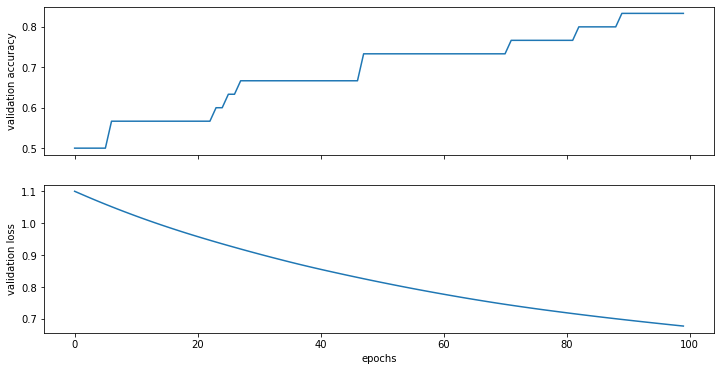

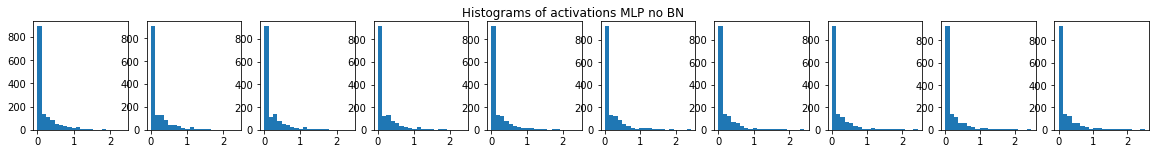

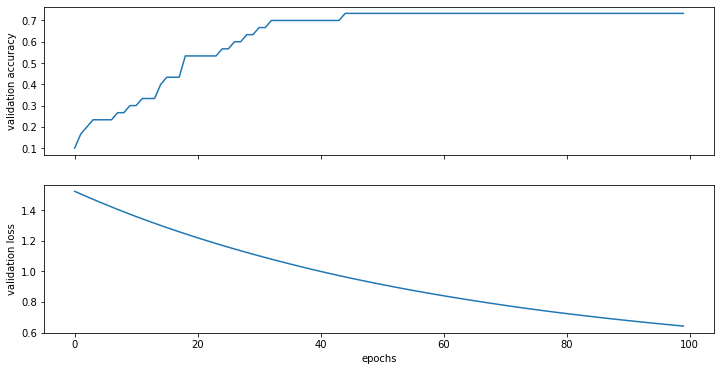

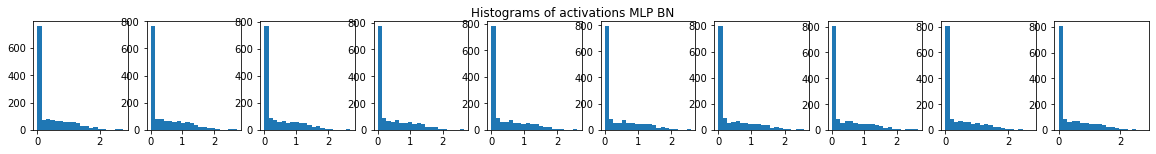

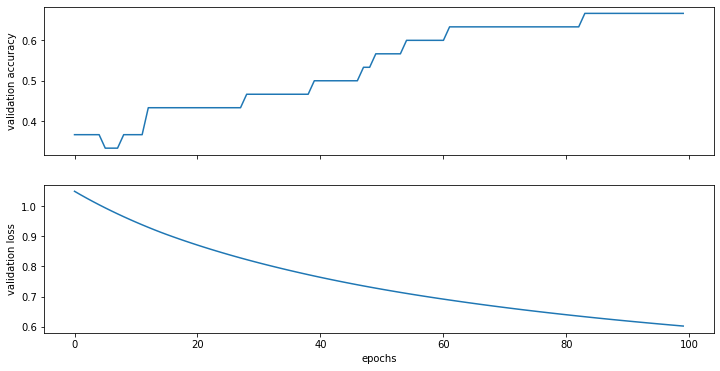

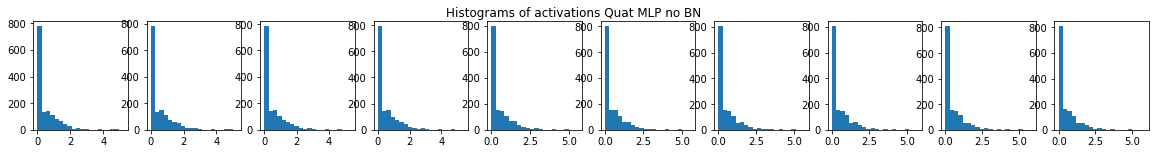

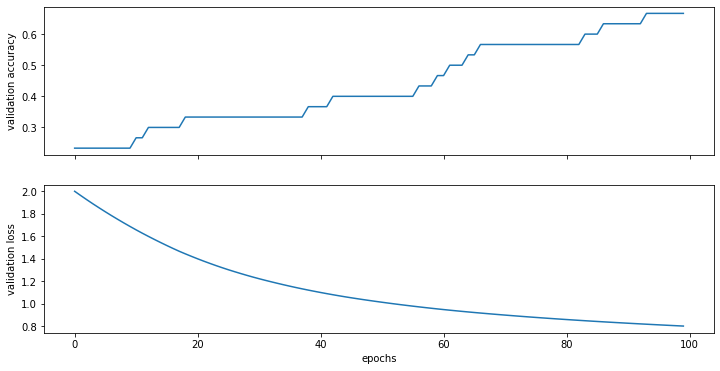

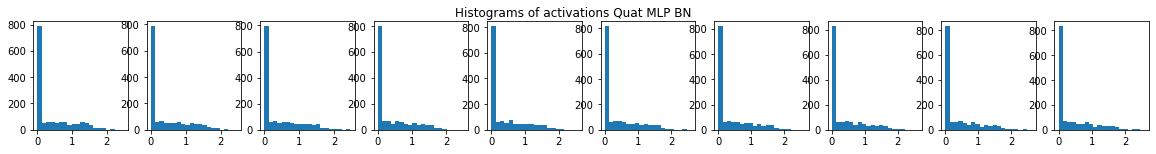

In [8]:
for name, model in models.items():
    loss, accuracy, activations = train(model, X_train, y_train, X_test, y_test, num_epochs=100)

    # display accuracy and loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
    ax1.plot(accuracy)
    ax1.set_ylabel("validation accuracy")
    ax2.plot(loss)
    ax2.set_ylabel("validation loss")
    ax2.set_xlabel("epochs")
    plt.savefig(f"{name}_accuracy.png")

    # Plot histograms of activations
    plt.figure(figsize=(20, 2))
    for j, a in enumerate(activations[::10]):
        plt.subplot(1, 10, j+1)
        plt.hist(a, bins=20)
    plt.suptitle("Histograms of activations {}".format(name))

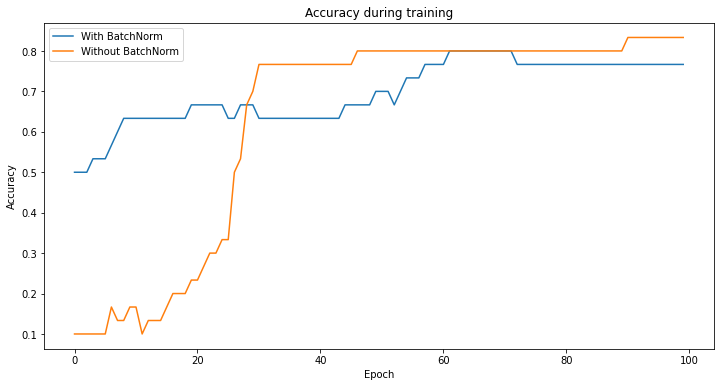

In [9]:
model_no_bn = MLP(4, 16, quaternion=False, use_batch_norm=False, proper_bn=False)
model_bn = MLP(4, 16, quaternion=False, use_batch_norm=True, proper_bn=False)
loss_no_bn, accuracy_no_bn, activations_no_bn = train(model_no_bn, X_train, y_train, X_test, y_test, num_epochs=100)
loss_bn, accuracy_bn, activations_bn = train(model_bn, X_train, y_train, X_test, y_test, num_epochs=100)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy_bn, label="With BatchNorm")
plt.plot(accuracy_no_bn, label="Without BatchNorm")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy during training")
plt.savefig("accuracy_real.png")